In [1]:
import numpy as np           # linear algebra
import pandas as pd          # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from matplotlib.image import imread
import os

# Approach to solve this problem will include:

### 1. Selecting the best dimensions for the images
### 2. Generate more sample images out of sample data to generalize the model
### 3. Apply Random image transformations
### 4. Feed the data into model
### 5. Hope for the best results!

# Exploring the datasets 

In [9]:
path='C:/Users/DELL/Downloads/dataset/data'

### Listing the test and training datasets

In [10]:
os.listdir(path)

['test', 'train']

In [11]:
test_path=path+'/test/'
train_path=path+'/train/'

### First image in African folder

In [12]:
os.listdir(test_path+'African/')[0]

'af_te1.jpg'

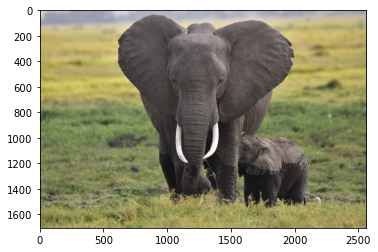

In [13]:
plt.imshow(imread(test_path+'/African/af_te43.jpg'))

# Deciding the dimensions for our input data

### Use the average dimension out from all of the images

In [14]:
dim1=[]
dim2=[]

for pic in os.listdir(train_path+'Asian'):
    img=imread(train_path+'Asian'+'/'+pic)
    d1,d2,d3=img.shape
    dim1.append(d1)
    dim2.append(d2)

### Picking best dimension

In [16]:
image_size=(100,100,3)

# Generating more data to generalize the model
### using *ImageDataGenerator*

In [17]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [18]:
test=os.listdir(test_path+'Asian/')[0]
test=plt.imread(test_path+'Asian/as_te87.jpg')

In [19]:
image_gen=ImageDataGenerator(rotation_range=20,
                            width_shift_range=0.2,
                            height_shift_range=0.2,
                            rescale=1/255,
                             shear_range=0.1,
                             zoom_range=0.1,
                             horizontal_flip=True,
                             vertical_flip=True,
                             fill_mode='nearest'
                            )

### Random image after transformation

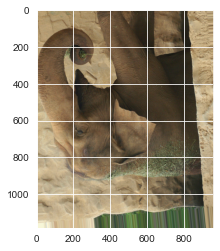

In [20]:
plt.imshow(image_gen.random_transform(test))

In [21]:
image_gen.flow_from_directory(train_path)

Found 840 images belonging to 2 classes.


# Creating CNN Model
### using Convolution, MaxPooling, Dense, Dropout and Flatten layers

In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, MaxPool2D, Conv2D, Dense, Flatten

In [23]:
model= Sequential([
    Conv2D(64, kernel_size=(3,3),activation='relu',input_shape=image_size),
    MaxPool2D((2,2)),
    
    Conv2D(128, kernel_size=(3,3),activation='relu'),
    MaxPool2D((2,2)),
    
    Conv2D(128, kernel_size=(3,3),activation='relu'),
    MaxPool2D((2,2)),
    
    Flatten(),
    
    Dense(256, activation='relu'),
    Dropout(0.5),
    
    Dense(1, activation='sigmoid')
])

In [24]:
model.compile(loss='binary_crossentropy',metrics=['accuracy'],optimizer='adamax')

In [25]:
from tensorflow.keras.callbacks import EarlyStopping
call=EarlyStopping(patience=5, min_delta=0.0001,monitor='val_loss')

# Generating more train and test images

In [26]:
train_img=image_gen.flow_from_directory(train_path,
                                     target_size=image_size[:2],
                                     color_mode='rgb',
                                     batch_size=16,
                                     class_mode='binary')

Found 840 images belonging to 2 classes.


In [27]:
test_img=image_gen.flow_from_directory(test_path,
                                     target_size=image_size[:2],
                                     color_mode='rgb',
                                     batch_size=8,
                                     class_mode='binary',
                                      shuffle=False)

Found 188 images belonging to 2 classes.


# Fitting the model

In [30]:
results=model.fit_generator(train_img,
                           callbacks=[call],
                           validation_data=test_img,
                           epochs=4)

Epoch 1/4


<ipython-input-30-79f07672de4b>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  results=model.fit_generator(train_img,


53/53 [==============================] - 36s 672ms/step - loss: 0.6917 - accuracy: 0.5357 - val_loss: 0.6866 - val_accuracy: 0.4840
Epoch 2/4
53/53 [==============================] - 38s 720ms/step - loss: 0.6912 - accuracy: 0.5369 - val_loss: 0.6783 - val_accuracy: 0.6223
Epoch 3/4
53/53 [==============================] - 38s 714ms/step - loss: 0.6909 - accuracy: 0.5155 - val_loss: 0.6785 - val_accuracy: 0.5372
Epoch 4/4
53/53 [==============================] - 38s 714ms/step - loss: 0.6911 - accuracy: 0.5405 - val_loss: 0.6810 - val_accuracy: 0.6170


In [33]:
loss=pd.DataFrame(model.history.history)

# Visualizing the loss and Accuracy of CNN model

<AxesSubplot:>

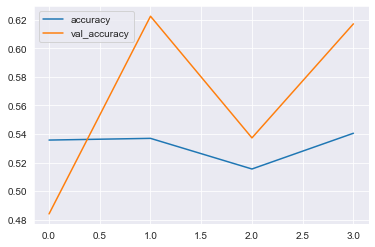

In [34]:
loss[['accuracy','val_accuracy']].plot()

<AxesSubplot:>

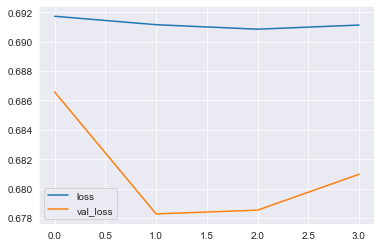

In [35]:
loss[['loss','val_loss']].plot()

# Evaluating the model's performance

In [36]:
model.evaluate_generator(test_img)

<ipython-input-36-48713739b211>:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  model.evaluate_generator(test_img)


[0.6818558573722839, 0.6117021441459656]

In [37]:
pred=model.predict_generator(test_img)

<ipython-input-37-24febda13125>:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  pred=model.predict_generator(test_img)


In [38]:
predd=pred>0.5

## Generating Classification report and Confusion Matrix

In [39]:
from sklearn.metrics import classification_report, confusion_matrix

In [40]:
print(classification_report(test_img.classes,predd))

              precision    recall  f1-score   support

           0       0.60      0.89      0.71        97
           1       0.75      0.36      0.49        91

    accuracy                           0.63       188
   macro avg       0.67      0.62      0.60       188
weighted avg       0.67      0.63      0.60       188



In [41]:
confusion_matrix(test_img.classes, predd)

array([[86, 11],
       [58, 33]], dtype=int64)